[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_normal_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_ddos_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_dos_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_injection_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_backdoor_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_runsomware_df.pkl]
[10-06-2025 16:57:43] [pypickle.pypickle] [INFO] Loading Pickle file: [/home/hsp252/Development/HSP_IDS/test_mitm_df.pkl]
/opt/Miniconda/envs/jannis_env/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-v

best params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 1000}
accurracy: 0.9833333333333333


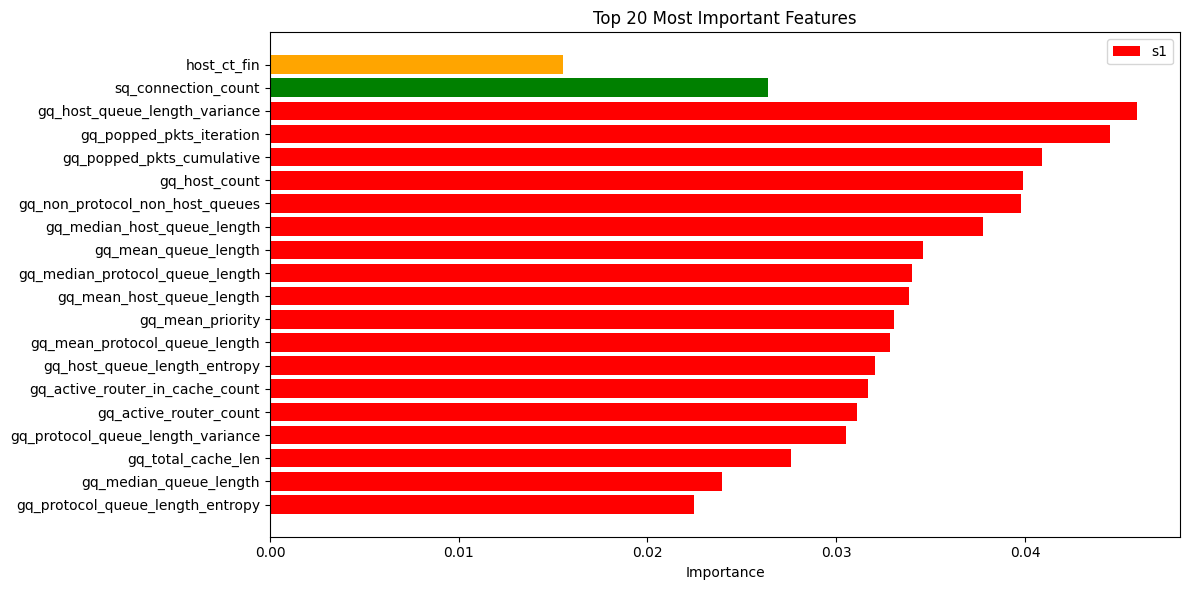

In [ ]:
import data_analysis.data_processing as dp
import data_analysis.data_learning as dl

# reload module to bypass caching
import importlib
importlib.reload(dp)
importlib.reload(dl)

# paths
test_window_path_home = dp.Path(r'\\?\C:\Users\jannis\Documents\HSP_IDS\Material\Aktuell\2025-02-17_11-14-33_192.168.1.0-normal_1\1554220324.748197-1554220354.748197') # treat it as a long path to avoid path length issues on windows
test_window_path_remote = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-03-04_00-03-20_192.168.1.0-normal_DDoS_1/1556203726.876922-1556203756.876922')

data_set_path = dp.Path(r'/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes')
ddos_test_path_parquet = dp.Path(r'/home/hsp252/Development/DDoS')

# get host-based fvs
fvs = dp.pd.DataFrame()
labels = dp.pd.DataFrame()

normal = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_normal_df.pkl')
labels = dp.pd.concat([labels, normal['attack_type']])
fvs = dp.pd.concat([fvs, normal])

ddos = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_ddos_df.pkl')
labels = dp.pd.concat([labels, ddos['attack_type']])
fvs = dp.pd.concat([fvs, ddos])

dos = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_dos_df.pkl')
labels = dp.pd.concat([labels, dos['attack_type']])
fvs = dp.pd.concat([fvs, dos])

injection = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_injection_df.pkl')
labels = dp.pd.concat([labels, injection['attack_type']])
fvs = dp.pd.concat([fvs, injection])

backdoor = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_backdoor_df.pkl')
labels = dp.pd.concat([labels, backdoor['attack_type']])
fvs = dp.pd.concat([fvs, backdoor])

runsomeware = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_runsomware_df.pkl')
labels = dp.pd.concat([labels, runsomeware['attack_type']])
fvs = dp.pd.concat([fvs, runsomeware])

mitm = dp.pp.load('/home/hsp252/Development/HSP_IDS/test_mitm_df.pkl')
labels = dp.pd.concat([labels, mitm['attack_type']])
fvs = dp.pd.concat([fvs, mitm])

fvs = fvs.iloc[:, 4:].drop('attack_type', axis=1)

# create and train rfc
best_params, predictions, accuracy, feature_importances = dl.rfc(fvs, labels)

print(f"best params: {best_params}")
print(f"accurracy: {accuracy}")

# plot feature importances
feature_importance_df = dp.pd.DataFrame({'feature': fvs.columns, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
important_features = feature_importance_df['feature'][:20][::-1].to_numpy()
important_features_values = feature_importance_df['importance'][:20][::-1].to_numpy()

s1_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/s1_general_qs.csv').to_list()
connection_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/connections/1556466432.434372-1556466442.434372/96.0_192.168.1.193_49338.0_192.168.1.152_1880.0/host_data_chunk_full.csv').to_list()
s2_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/s2_selected_qs.csv').to_list()
s3_cols = dl.get_feature_names_from_csv('/home/hsp252/nas_mount/hunter.ids.data/hunter.ids.preprocessor/processed_dataframes/angriff/2025-02-28_08-41-32_192.168.1.0-normal_backdoor/1556466432.434372-1556466462.434372/192.168.1.152/s3_connection_qs.csv').to_list()

s1_mask = [i for i, feature in enumerate(important_features) if feature in s1_cols]
s2_mask = [i for i, feature in enumerate(important_features) if feature in s2_cols]
s3_mask = [i for i, feature in enumerate(important_features) if feature in s3_cols]
connection_mask = [i for i, feature in enumerate(important_features) if feature in connection_cols]

dp.plt.figure(figsize=(12, 6))
if s1_mask:
        dp.plt.barh(important_features[s1_mask], important_features_values[s1_mask], color = 'red', label='s1')
if s2_mask:
        dp.plt.barh(important_features[s2_mask], important_features_values[s2_mask], color = 'blue', label='s2')
if s3_mask:
        dp.plt.barh(important_features[s3_mask], important_features_values[s3_mask], color = 'green', label='s3')
if connection_mask:
        dp.plt.barh(important_features[connection_mask], important_features_values[connection_mask], color = 'orange', label='connection')
dp.plt.xlabel("Importance")
dp.plt.title("Top 20 Most Important Features")
dp.plt.tight_layout()
dp.plt.legend()
dp.plt.show()

#TODO: identify features in s1, s2,... to evaluate feature sets

    

#TODO: apply more data (balance classes)
#TODO: try other/more parameters in grid


# test_ddos_parquet = dp.pd.read_parquet('../DDoS/intrusion_normal_DDoS_10_final.parquet')
# test_ddos_parquet_cleaned = test_ddos_parquet[17:].select_dtypes(include='number')
# bool_columns = test_ddos_parquet_cleaned.select_dtypes(include='bool').columns
# test_ddos_parquet_cleaned[bool_columns] = test_ddos_parquet_cleaned[bool_columns].astype(float)


